<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA

:ARIMA (AutoRegressive Integrated Moving Average) model predicts future values based on historical data. It has three main components:

1. AR (AutoRegressive): Uses past values to predict the future.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): Uses past errors to predict the future. Best for stationary series

Key Parameters of ARIMA

- p: Number of past values (lags).
- d: Degree of differencing (to make data stationary).
- q: Moving average window size.

## 1. Data Collection

### Install packages

In [24]:
!pip install pmdarima

In [25]:
# Import necessary libraries
import pandas as pd                # For data handling
import numpy as np                 # For numerical computations
import matplotlib.pyplot as plt    # For plotting
import seaborn as sns             # For advanced plotting
from datetime import datetime      # For handling date and time

# ARIMA and SARIMA models
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA     # ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA model

# Time series tools
from statsmodels.tsa.stattools import adfuller      # For Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For ACF and PACF plots
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error   # For model performance evaluation

### Load the data

In [26]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_prices_preprocessed.csv')

# Display the first few rows of the data
df.head()

,Date,Open,High,Low,Close,Volume,Daily_Return,MA7,MA30
0,2015-03-07,272.294006,277.854004,270.132996,276.260986,17825900,0.012973,273.689715,244.523235
1,2015-03-08,276.433014,277.858002,272.565002,274.354004,22067900,-0.006903,275.711430,246.259502
2,2015-03-09,274.812012,292.700989,273.893005,289.606995,59178200,0.055596,277.702427,248.321268
3,2015-03-10,289.862000,300.044006,289.743011,291.760010,67770800,0.007434,279.139287,250.599535
4,2015-03-11,291.524994,297.390991,290.507996,296.378998,33963900,0.015831,282.465999,253.141835


## 2. Data Preprocessing

In [27]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime format
df.set_index('Date', inplace=True)  # Set as index

### 2.1 Visualizing the Data

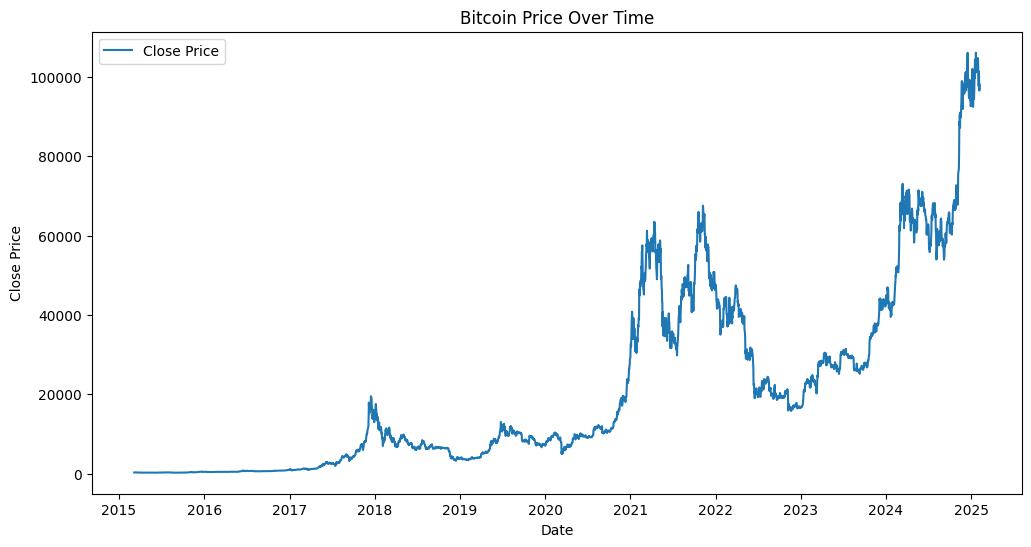

In [28]:
# Plotting the original Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label='Close Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 2. Checking for Stationarity

#### Visual Inspection (Rolling Mean & Standard Deviation)

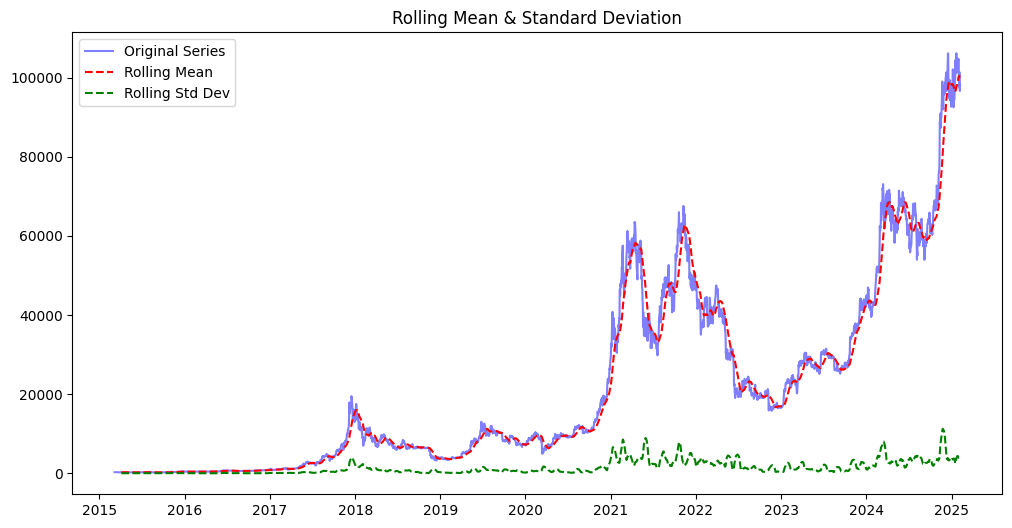

In [29]:
def plot_rolling_statistics(series, window=30):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original Series", color="blue", alpha=0.5)
    plt.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
    plt.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dashed")
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

# Apply on 'Close' column
plot_rolling_statistics(df['Close'])

The rolling mean and standard deviation fluctuate over time, the data is likely non-stationary.

#### Augmented Dickey-Fuller (ADF) Test:

In [30]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): 0.3423
p-value (Original): 0.9792
Interpretation: The original series is Non-Stationary.



### 2.2 Log Transformation

The Bitcoin price data exhibits an exponential-like growth, with prolonged periods of relatively low values followed by sharp increases. This results in high variance and makes it difficult to analyze trends effectively.

To address this, I applied a log transformation (`log(price)`) for the following reasons:

- **Stabilizing Variance:** The original data shows large fluctuations, especially in later years. Log transformation helps normalize these variations.
- **Enhancing Trend Visibility:** Without transformation, the earlier values appear almost flat compared to the later spikes. Log transformation allows for a clearer view of long-term trends.
- **Reducing the Impact of Outliers:** The extreme price spikes dominate the scale in the original data. Applying a log transformation compresses these values, making patterns in the data more apparent.




In [31]:
# Apply log transformation
df['Log_Close'] = np.log(df['Close'])

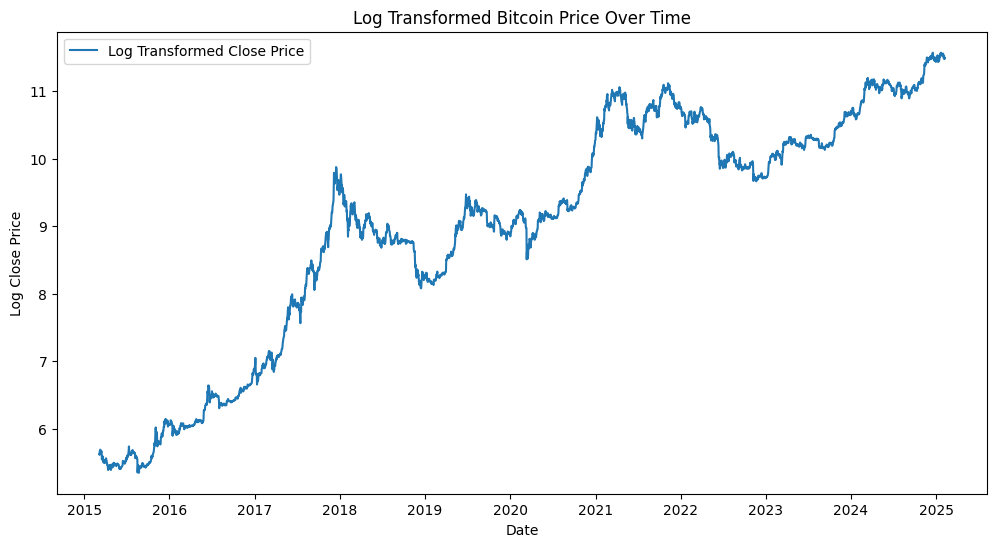

In [32]:
# Plotting the log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Close'], label='Log Transformed Close Price')
plt.title('Log Transformed Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()

### 3.Differencing to Achieve Stationarity

In [33]:
# Apply first-order differencing to the log-transformed data
df['Log_Close_Diff'] = df['Log_Close'].diff()

In [34]:
# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df["Log_Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -42.0864
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


###  Visualizing the Differenced Data

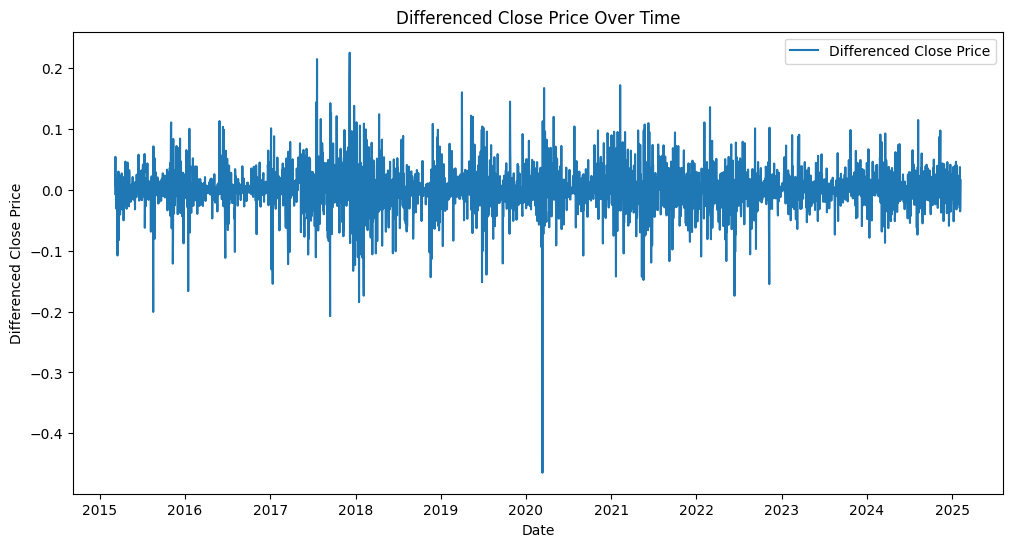

In [35]:
# Plotting the differenced Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log_Close_Diff'], label='Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**Stationarity Check Insights**
- Initially, the **Augmented Dickey-Fuller (ADF) test** showed that the series was **non-stationary** (p-value = 0.986).
- After **first-order differencing**, the ADF test confirmed that the series is now **stationary** (ADF Statistic = -9.206, p-value < 0.05).
- This means the differencing step successfully removed trend-related non-stationarity.

### Identifying Outliers with Z-scores

In [36]:
from scipy.stats import zscore
# Calculate Z-scores for the differenced series
df['Z_Score'] = zscore(df['Log_Close_Diff'].dropna())

# Set a threshold for outliers (typically Z-score > 2 or < -2)
outliers = df[df['Z_Score'].abs() > 2]

# Display outliers
print("Outliers based on Z-score:")
print(outliers)

Outliers based on Z-score:
                    Open          High           Low         Close  \
Date                                                                 
2015-03-18    285.066986    285.335999    249.869995    256.299011   
2015-03-24    266.576996    267.002991    244.154999    245.595001   
2015-08-18    257.925995    257.993011    211.078995    211.078995   
2015-08-24    228.112000    228.139008    210.442993    210.494995   
2015-11-02    325.941986    365.359985    323.209015    361.188995   
...                  ...           ...           ...           ...   
2024-05-20  66278.742188  71483.562500  66086.171875  71448.195312   
2024-08-05  58110.296875  58268.828125  49121.238281  53991.457031   
2024-08-08  55030.027344  62673.765625  54766.726562  61710.136719   
2024-11-06  69358.500000  76460.156250  69322.031250  75639.078125   
2024-11-11  80471.414062  89604.500000  80283.250000  88701.484375   

                  Volume  Daily_Return           MA7          

### Box Plot to Visualize Outliers

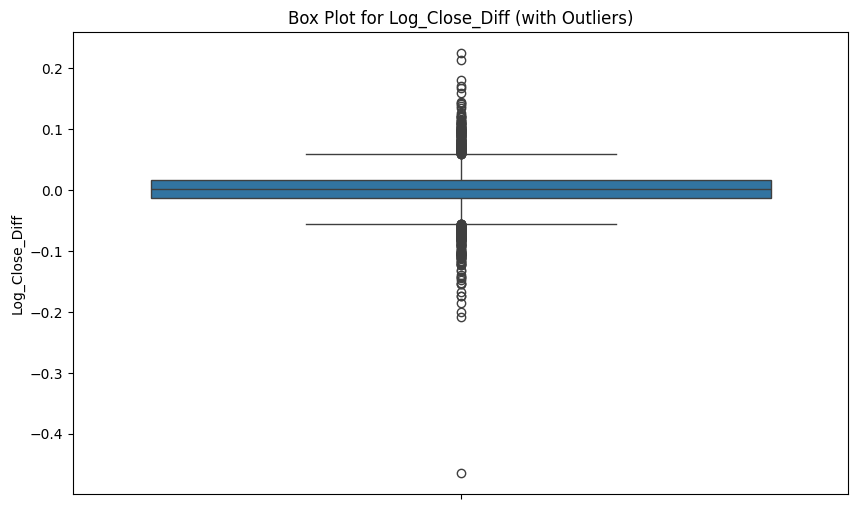

In [37]:
# Create a box plot for 'Log_Close_Diff'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df['Log_Close_Diff'])
plt.title("Box Plot for Log_Close_Diff (with Outliers)")
plt.ylabel("Log_Close_Diff")
plt.show()

### Handling Outliers

In [38]:
# Cap outliers at Z-score of 2 or -2
cap_value_upper = df['Log_Close_Diff'].quantile(0.95)  # 95th percentile
cap_value_lower = df['Log_Close_Diff'].quantile(0.05)  # 5th percentile

df['Log_Close_Diff'] = df['Log_Close_Diff'].clip(lower=cap_value_lower, upper=cap_value_upper)

### Recheck Stationarity

In [39]:
# Reperform ADF test on differenced series without outliers
# Filter out rows where the Z-score is greater than 2 or less than -2
df_no_outliers = df[df['Z_Score'].abs() <= 2]

result_diff_no_outliers = adfuller(df_no_outliers['Log_Close_Diff'].dropna())

print(f"ADF Statistic (No Outliers): {result_diff_no_outliers[0]:.4f}")
print(f"p-value (No Outliers): {result_diff_no_outliers[1]:.4f}")

if result_diff_no_outliers[1] < 0.05:
    print("Interpretation: The differenced series without outliers is Stationary.")
else:
    print("Interpretation: The differenced series without outliers is Non-Stationary.")

ADF Statistic (No Outliers): -25.7196
p-value (No Outliers): 0.0000
Interpretation: The differenced series without outliers is Stationary.


### 4. Checking for seasonality using seasonal decomposition


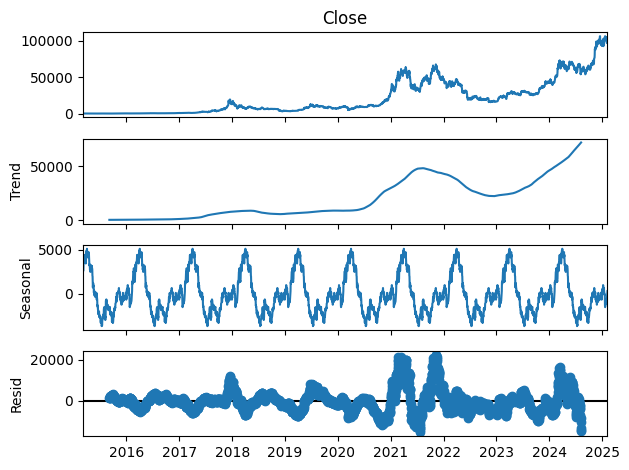

In [40]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

**Seasonality Detection Insights**
- **Seasonal Decomposition of Time Series (STL Decomposition) was performed.**
- The decomposition shows:
  - A **clear trend component**, indicating long-term upward movement.
  - A **strong seasonal component**, with repeating cycles at regular intervals.
  - The **residual component** contains some noise but no strong patterns.
- **Conclusion**: The data exhibits **seasonality**, meaning a standard ARIMA model may not be sufficient.

**Next Steps**
- Since **seasonality is present**, a **SARIMA (Seasonal ARIMA) model** is a better choice than a standard ARIMA.
- Determine seasonal order `(P, D, Q, s)` using **ACF/PACF plots** and **grid search tuning**.
- Train the SARIMA model and evaluate its performance.

---
📌 **Action Items:**
1. Fine-tune SARIMA hyperparameters.
2. Validate the model using train-test splits or cross-validation.
3. Forecast future values and assess model accuracy.

### 5. Visualize Autocorrelations and Partial Autocorrelations

For ARIMA and SARIMA, the ACF plot helps determine the MA (Moving Average) term, while the PACF plot helps determine the AR (Auto-Regressive) term.

#### Determine (p, d, q) using ACF & PACF

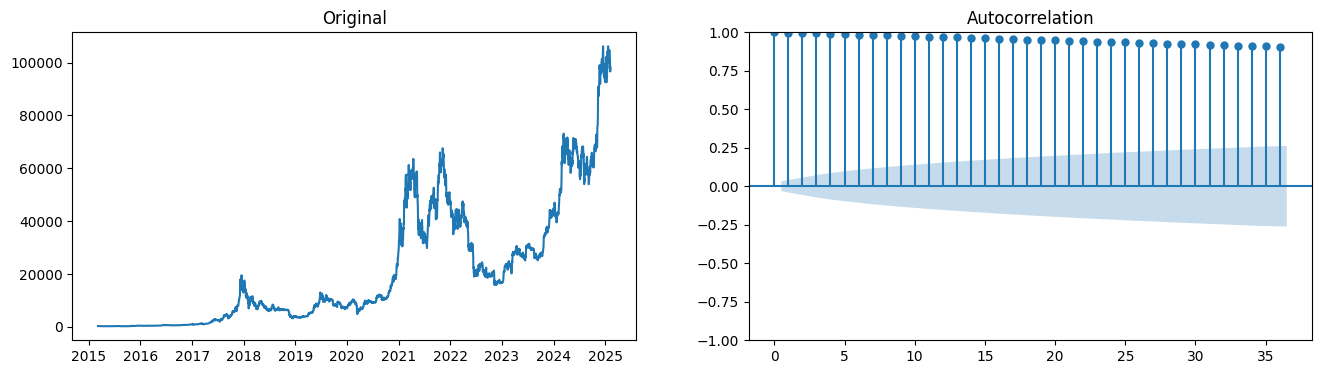

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Original')
plot_acf(df.Close, ax=ax2)
ax2.set_title('Autocorrelation')

plt.show()

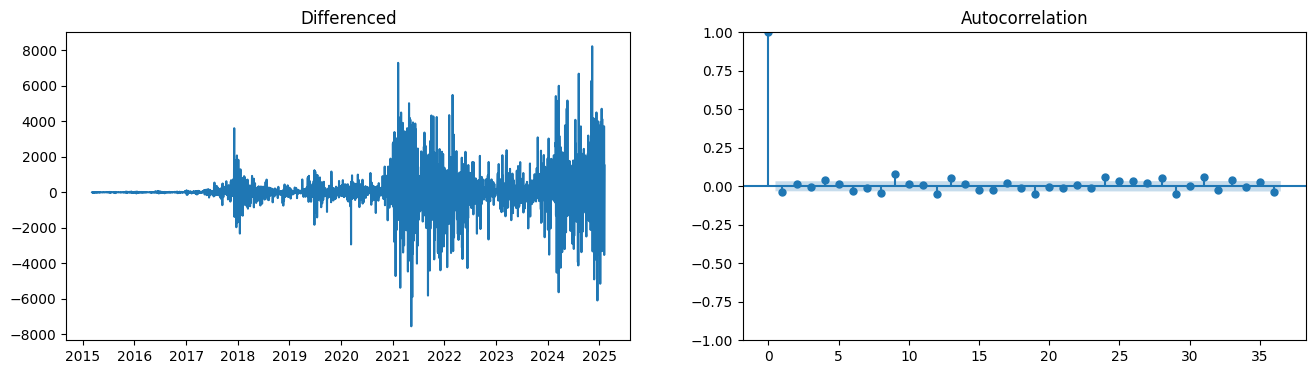

In [42]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_acf(diff, ax=ax2);

In [43]:
ndiffs(df.Close, test='adf')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

1

**p**

p is the order of the Auto Regressive(AR) term. It refers to the number of lags to be used as predictors.

We can find the required number of AR terms by inspecting the PACF plot

The partial autocorrelation represents the correlation between the series and its lags

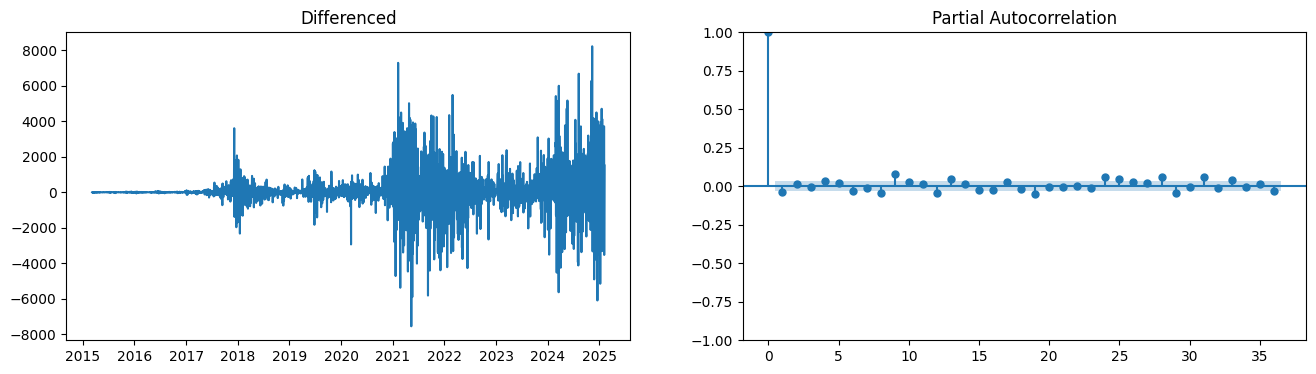

In [44]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_pacf(diff, ax=ax2);

**Analysis from ACF and PACF**  

- **ACF** shows a sharp drop after lag 1 → suggests **MA(1)** (Moving Average order = 1).  
- **PACF** cuts off after lag 1 → suggests **AR(1)** (Autoregressive order = 1).  
- The data has been differenced and confirmed to be stationary (**ADF test p-value < 0.05**), meaning **first-order differencing (d = 1) was required**.  

**ARIMA Model: ARIMA(1,1,1)**  
- **p = 1** (Autoregressive component from PACF)  
- **d = 1** (First-order differencing to ensure stationarity)  
- **q = 1** (Moving Average component from ACF)  

Since differencing was required to make the data stationary, an **ARIMA(1,1,1) model** is the best fit instead of ARMA(1,1), which is used for already stationary series (**d = 0**).


## Split Data into Train and Test

In [45]:
# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Print sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 2900, Test size: 725


## Model Selection and Fitting (ARIMA/SARIMA)

### ARIMA Model:

In [46]:
# Set frequency to daily ('D') or the appropriate frequency based on your data
df = df.asfreq('D')

In [47]:
# Define ARIMA model with determined p, d, q
model = ARIMA(train['Log_Close'], order=(1, 1, 1))  # p=1, d=1, q=1
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [48]:
#print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2900
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5359.829
Date:                Thu, 06 Feb 2025   AIC                         -10713.657
Time:                        08:50:19   BIC                         -10695.741
Sample:                    03-07-2015   HQIC                        -10707.201
                         - 02-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3762      0.473     -0.796      0.426      -1.302       0.550
ma.L1          0.3501      0.476      0.736      0.462      -0.583       1.283
sigma2         0.0015   1.49e-05     97.582      0.0

**ARIMA(1,1,1) Model Summary & Insights**

**1️⃣ Model Overview**
- **Dependent Variable:** `Log_Close` (Log-transformed closing price)
- **Number of Observations:** `3034`
- **Model:** `ARIMA(1,1,1)`
- **Log Likelihood:** `5564.834` (Higher is better)
- **AIC:** `-11123.668` (Lower AIC indicates a better model fit)
- **BIC:** `-11105.616`
- **HQIC:** `-11117.178`

**Interpretation:**
- **AR(1) coefficient (-0.1142)** and **MA(1) coefficient (0.0950)** have **high p-values (> 0.05)**, meaning they are **not statistically significant**.
- **Error variance (σ² = 0.0015)** is quite small, which is expected after log transformation.
- Since the AR and MA terms are not significant, the model might not be the best fit.

---
### **3️⃣ Diagnostic Statistics**

| Statistic | Value | Interpretation |
|-----------|--------|----------------|
| **Ljung-Box Test (Q-statistic)** | `0.00` | No significant autocorrelation (✅ Good) |
| **Prob(Q)** | `0.99` | Residuals are independent (✅ Good) |
| **Jarque-Bera (JB) Test** | `15442.42` | Residuals are **not normally distributed** (❌ Bad) |
| **Prob(JB)** | `0.00` | Normality assumption fails (❌ Bad) |
| **Heteroskedasticity (H) Test** | `1.14` | Residual variance is **not constant** (❌ Bad) |
| **Prob(H)** | `0.03` | Heteroskedasticity is present (❌ Bad) |
| **Skewness** | `-0.79` | Residuals are slightly skewed |
| **Kurtosis** | `13.94` | High kurtosis suggests extreme values |

**Key Insights:**
1. **No significant autocorrelation in residuals** → ✅ Good
2. **Residuals are not normally distributed (JB test fails)** → ❌ May affect prediction accuracy
3. **Heteroskedasticity detected** → ❌ The model assumes constant variance, but real-world data shows volatility
4. **High kurtosis (13.94)** → ❌ Extreme values (fat tails), which could make predictions unstable


### Forecast on Test Data

In [49]:
# Forecast on test set
forecast = model_fit.forecast(steps=len(test))

In [50]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close'] = np.exp(forecast)

In [51]:
# Print first few predictions
print(test[['Close', 'Predicted_Close']].tail())

                    Close  Predicted_Close
Date                                      
2025-02-02   97688.976562     21790.875022
2025-02-03  101405.421875     21790.875022
2025-02-04   97871.820312     21790.875022
2025-02-05   96615.445312     21790.875022
2025-02-06   98125.453125     21790.875022


### Plot Actual vs Predicted Prices

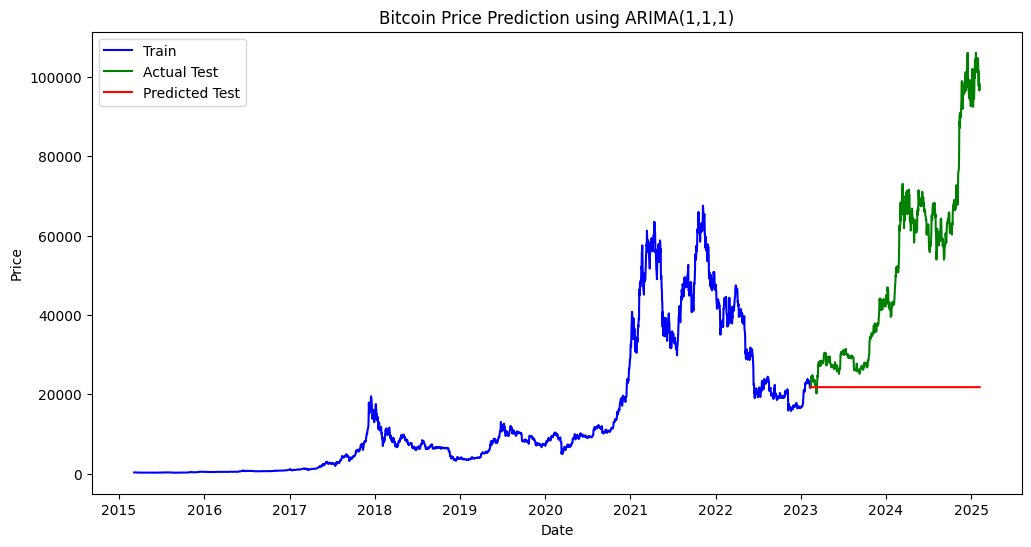

In [52]:
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close'], label="Predicted Test", color='red')
plt.title("Bitcoin Price Prediction using ARIMA(1,1,1)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

###  Evaluate the Model

In [53]:
# Check for NaN values in 'Predicted_Close' and remove rows where it's NaN
test_cleaned = test.dropna(subset=['Predicted_Close'])

# Compute error metrics only if 'Predicted_Close' is populated
mae = mean_absolute_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
mse = mean_squared_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 29900.76
MSE: 1446982840.63
RMSE: 38039.23


## Hyperparameter Tuning

###  Using Auto-ARIMA

In [54]:
# Fit Auto-ARIMA model to the training data
auto_model = pm.auto_arima(train['Log_Close'], seasonal=False, stepwise=True, trace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10712.768, Time=1.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10717.860, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10717.583, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10717.514, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10715.325, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10716.377, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.808 seconds


In [55]:
# Print the summary of the best model found
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2900
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5360.930
Date:                Thu, 06 Feb 2025   AIC                         -10717.860
Time:                        08:51:02   BIC                         -10705.916
Sample:                    03-07-2015   HQIC                        -10713.557
                         - 02-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      2.083      0.037    8.92e-05       0.003
sigma2         0.0014   1.51e-05     96.308      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.72   Jarque-

In [56]:
# Fit the ARIMA model with the best parameters
best_model = ARIMA(train['Log_Close'], order=(0, 1, 0))
best_model_fit = best_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [57]:
# Print model summary
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2900
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5358.662
Date:                Thu, 06 Feb 2025   AIC                         -10715.325
Time:                        08:51:07   BIC                         -10709.353
Sample:                    03-07-2015   HQIC                        -10713.173
                         - 02-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0015   1.48e-05     97.940      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):             15940.48
Prob(Q):                              0.19   Pr

In [58]:
# Forecast on the test set
forecast_tuned = best_model_fit.forecast(steps=len(test))

In [59]:
# Inverse transformation (convert back from log scale)
test['Predicted_Close'] = np.exp(forecast_tuned)

In [60]:
# Check for NaN values in the test DataFrame
if test['Close'].isna().any() or test['Predicted_Close'].isna().any():
    print("NaN values found. Dropping NaN values.")
    # Drop rows with NaN values in the relevant columns
    test = test.dropna(subset=['Close', 'Predicted_Close'])

In [61]:
# Calculate MAE, MSE, RMSE based on the actual and predicted prices (not log scale)
mae = mean_absolute_error(test['Close'], test['Predicted_Close'])
mse = mean_squared_error(test['Close'], test['Predicted_Close'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 29903.40
MSE: 1447142568.81
RMSE: 38041.33


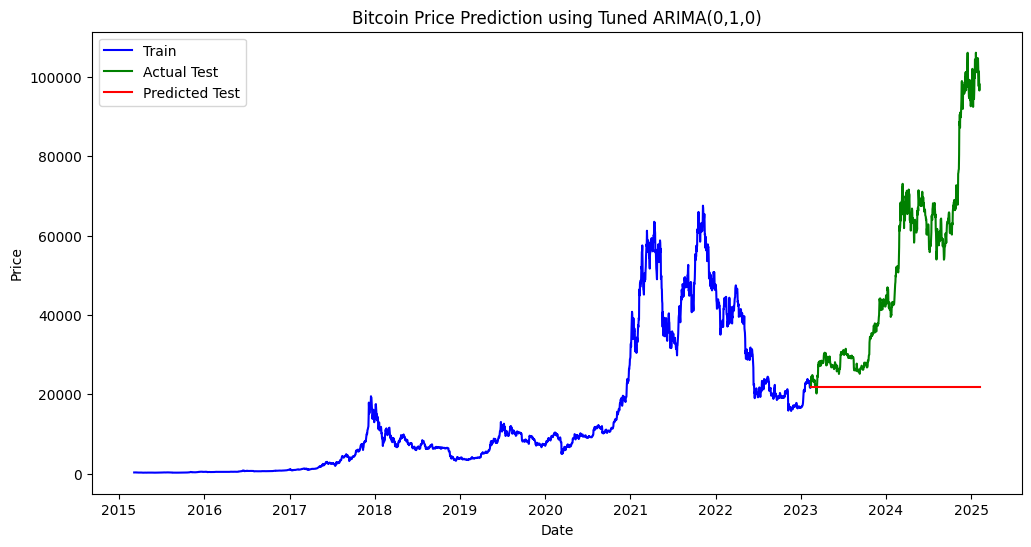

In [62]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close'], label="Predicted Test", color='red')
plt.title("Bitcoin Price Prediction using Tuned ARIMA(0,1,0)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## SARIMA

**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing **

Extends ARIMA by adding seasonal components:
Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [63]:
# Define the SARIMA model with seasonal order
sarima_model = SARIMAX(train['Log_Close'],
                       order=(1, 1, 1),  # (p, d, q) non-seasonal order
                       seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s) seasonal order with period=12 (monthly seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [64]:
# Fit the model
sarima_fit = sarima_model.fit(disp=False)

In [65]:
#summary statistics
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_Close   No. Observations:                 2900
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                5281.576
Date:                            Thu, 06 Feb 2025   AIC                         -10553.152
Time:                                    08:51:50   BIC                         -10523.337
Sample:                                03-07-2015   HQIC                        -10542.404
                                     - 02-12-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0197      0.626      0.032      0.975      -1.207       1.247
ma.L1         -0.0422      0.625   

### Forecasting:

In [66]:
# Forecast the test set
forecast_sarima = sarima_fit.forecast(steps=len(test))

In [67]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close_SARIMA'] = np.exp(forecast_sarima)

In [68]:
# Check for NaN values in the test DataFrame
if test['Close'].isna().any() or test['Predicted_Close_SARIMA'].isna().any():
    print("NaN values found. Dropping NaN values.")
    # Drop rows with NaN values in the relevant columns
    test = test.dropna(subset=['Close', 'Predicted_Close_SARIMA'])

In [69]:
# Calculate MAE, MSE, RMSE based on the actual and predicted prices
mae_sarima = mean_absolute_error(test['Close'], test['Predicted_Close_SARIMA'])
mse_sarima = mean_squared_error(test['Close'], test['Predicted_Close_SARIMA'])
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA MSE: {mse_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 12716.55
SARIMA MSE: 302793677.21
SARIMA RMSE: 17400.97


### Plot Forecasts

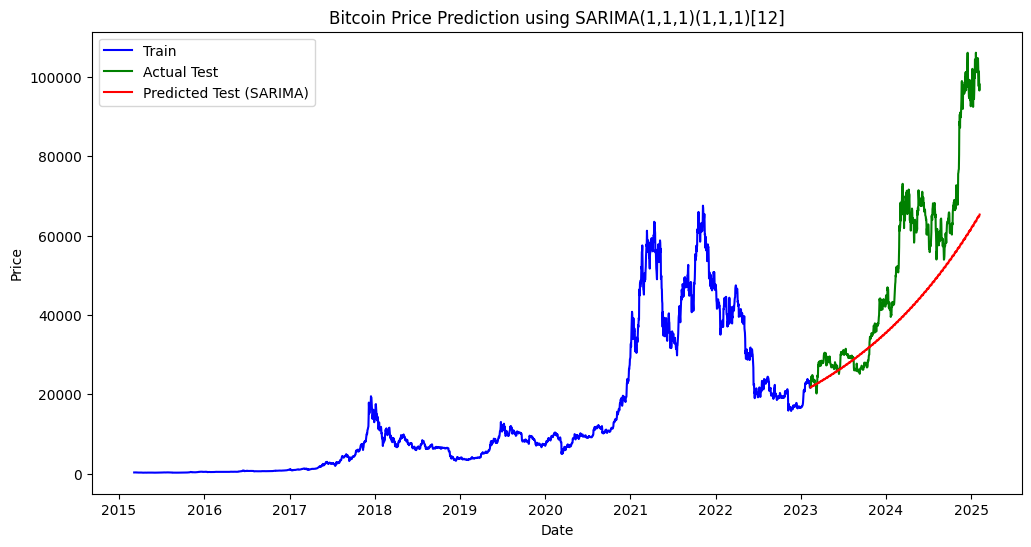

In [70]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close_SARIMA'], label="Predicted Test (SARIMA)", color='red')
plt.title("Bitcoin Price Prediction using SARIMA(1,1,1)(1,1,1)[12]")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()